In [1]:
library(arrow)
library(tidyverse)

readRenviron(".env")

dat_dir <- Sys.getenv("DAT_DIR")


Attaching package: ‘arrow’


The following object is masked from ‘package:utils’:

    timestamp


── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::duration() masks arrow::duration()
✖ dplyr::filter()       masks stats::filter()
✖ dplyr::lag()          masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [ ]:
dat_kp <- read_parquet(file.path(dat_dir, "CLEAR3_processed_2024-10-24", "dat_kp.parquet")) %>%
    mutate(
        date = as_date(keypressTimestampLocal),
        hour = hour(keypressTimestampLocal)
    )

head(dat_kp)

In [3]:
unique(dat_kp$keypress_type)

[1] "backspace"      "alphanum"       "other"          "autocorrection"
[5] "suggestion"     "@"              "punctuation"    "#"

Right-shift all timestamps by 5 hours so that all night-time periods end up with one date per period. We do the filtering on the night-time periods (i.e., the shifted data) because that is where this method requires its data to be.

In [ ]:
# Require each participant to have 1) >= 20% of their daily
# hours filled with some data, 2) >= 50 key presses per hour,
# and 3) >= 9 days of data
participants_included <- dat_kp %>%
    mutate(
        keypressTimestampLocal = keypressTimestampLocal + hours(5),
        date = as_date(keypressTimestampLocal),
        hour = hour(keypressTimestampLocal)
    ) %>%
    group_by(subject, date, hour) %>%
    summarize(
        n_key_presses = n() # Key presses per hour
    ) %>%
    group_by(subject, date) %>%
    summarize(
        prop_active_hours = n() / 24, # % hours with data
        avg_n_key_presses = median(n_key_presses)
    ) %>%
    group_by(subject) %>%
    summarize(
        avg_active_hours = mean(prop_active_hours),
        avg_n_key_presses = median(avg_n_key_presses),
        n_days = n(),
        include = avg_active_hours >= 0.2 & 
            avg_n_key_presses >= 50 & 
            n_days > 9
    ) %>%
    select(subject, include)

participants_included

In [ ]:
# Require at least 33% of hours to have some data

days_included <- dat_kp %>%
    mutate(
        keypressTimestampLocal = keypressTimestampLocal + hours(5),
        date = as_date(keypressTimestampLocal),
        hour = hour(keypressTimestampLocal)
    ) %>%
    group_by(subject, date) %>%
    summarize(n_active_hours = n_distinct(hour)) %>%
    mutate(include = n_active_hours / 24 >= 0.33) %>%
    select(!n_active_hours)

head(days_included)

In [ ]:
dat_filtered <- dat_kp %>%
    left_join(participants_included, by = "subject") %>%
    left_join(days_included, by = c("subject", "date")) %>%
    mutate(include = include.x & include.y) %>%
    filter(include) %>%
    select(!starts_with("include"))

head(dat_filtered)

In [ ]:
# dat_filtered has been time-shifted by +5 hours
dat_night <- dat_filtered %>%
    mutate(
        hour = hour(keypressTimestampLocal) + second(keypressTimestampLocal) / 60
    ) %>%
    filter(hour > 0, hour < 20) %>% # Between 19:00 and 15:00 after time shifting
    group_by(subject, date) %>%
    summarize(kap = max(diff(c(0, hour, 20)))) # Keystroke-absence period

head(dat_night)

In [ ]:
tmp <- dat_kp %>%
    mutate(
        keypressTimestampLocal = keypressTimestampLocal + hours(5),
        date = as_date(keypressTimestampLocal),
        hour = hour(keypressTimestampLocal) + second(keypressTimestampLocal) / 60
    )

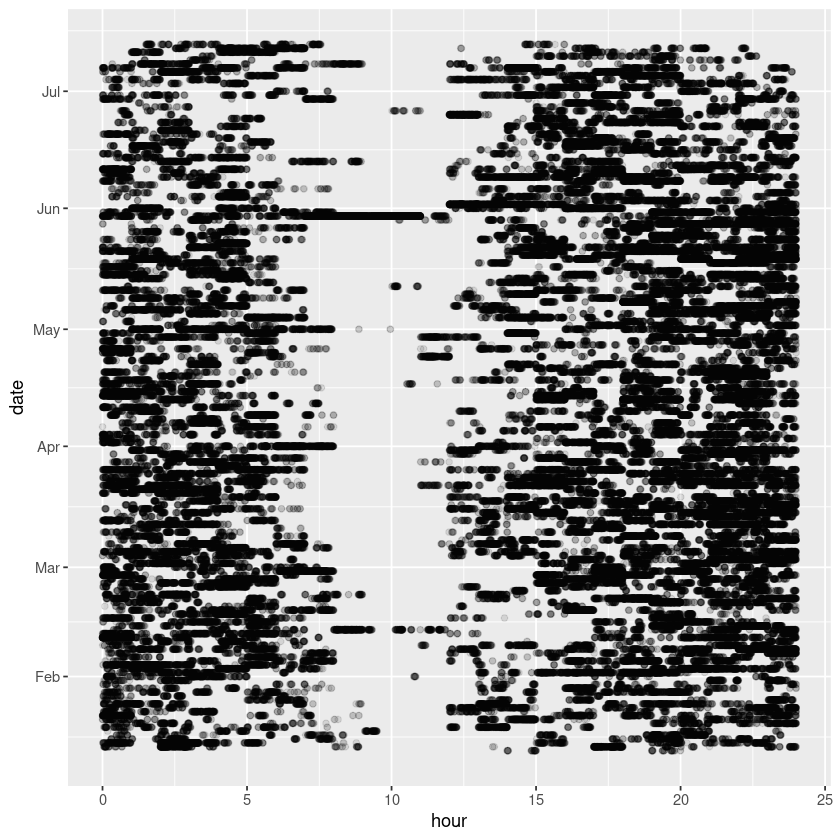

In [6]:
ggplot(tmp %>% filter(subject == "3009"), aes(hour, date)) +
    geom_point(alpha = 0.1)

In [ ]:
head(dat_night %>% filter(subject == "3009"))

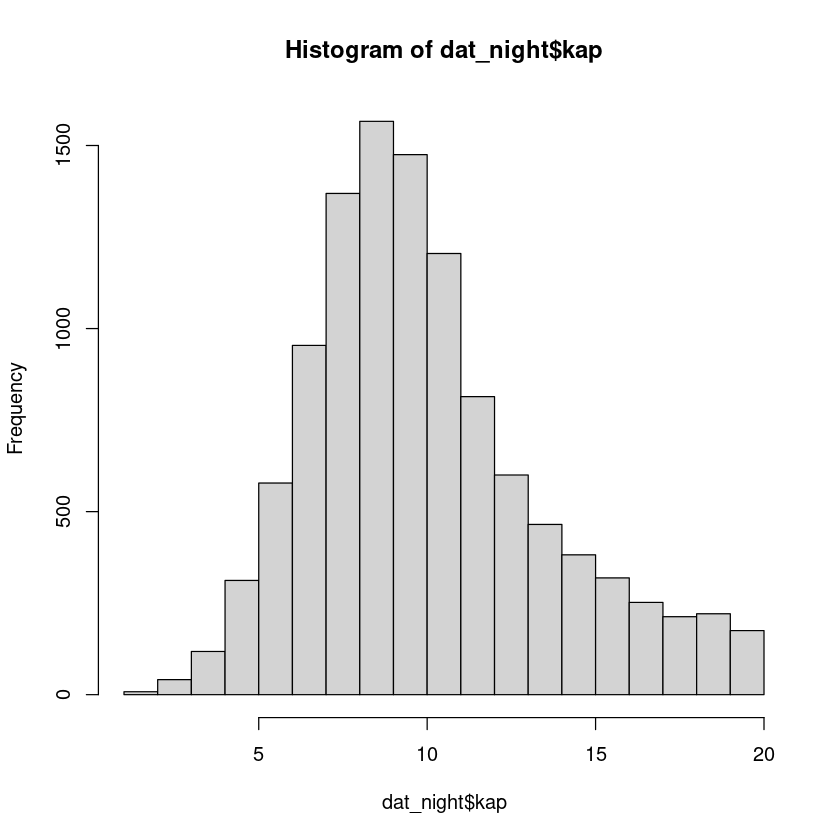

In [8]:
hist(dat_night$kap)

In [ ]:
# NOT time-shifted
dat_n_hours <- dat_kp %>%
    group_by(subject, date) %>%
    summarize(n_active_hours = n_distinct(hour)) %>%
    group_by(subject) %>%
    mutate(
        prev_date = lag(date),
        next_date = lead(date),
        prev_n_active_hours = lag(n_active_hours),
        next_n_active_hours = lead(n_active_hours)
    ) %>%
    # Ensure contiguity
    filter(date == prev_date + days(1), date == next_date - days(1)) %>%
    select(!c(prev_date, next_date))

head(dat_n_hours)

In [ ]:
# Data frame for the Druijff-Van de Woestijne method
dat_dvdw <- dat_night %>%
    left_join(dat_n_hours, by = c("subject", "date"))

head(dat_dvdw)

In [22]:
nrow(dat_dvdw)

[1] 7929

In [23]:
write_parquet(dat_dvdw, file.path(dat_dir, "dat_dvdw.parquet"))